# Introduction

In this notebook we try to classify images with a CNN.

Before, we have tried to classify images with a MLP which did not work since MLP do not provide basic operations as pooling in order to foster a translation invariant representation.

# Check dependencies

In [1]:
import matplotlib
print(matplotlib.__version__)

import numpy as np
print(np.__version__)

import cv2
print(cv2.__version__)

import pickle
print(pickle.format_version)

import tensorflow
print(tensorflow.__version__)

3.3.2
1.19.2
4.5.1
4.0
2.3.0


# Load in the image dataset generated before

In [2]:
fname = "../01_cnn_generating_image_data/persons_icons_dataset.pkl"

fobj = open(fname, "rb")
dataset = pickle.load(fobj)
fobj.close()

In [3]:
type(dataset)

list

In [4]:
len(dataset)

2

In [5]:
list_imgs, list_labels = dataset

In [6]:
len(list_imgs)

500

In [7]:
len(list_labels)

500

In [8]:
list_imgs[:2]

[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])]

In [9]:
list_labels[:2]

[2, 2]

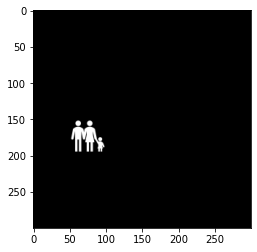

In [10]:
import matplotlib.pyplot as plt

plt.imshow(list_imgs[0], cmap="gray")
plt.show()

In [11]:
label = list_labels[0]
label

2

In [12]:
min(list_labels), max(list_labels)

(0, 4)

In [13]:
nr_object_classes = max(list_labels)+1
nr_object_classes

5

# Prepare input and output matrices

For training a MLP, where the inputs are 1-dimensional we need a 2D-matrix (for batch-learning) in Keras: in each row of this 2D-matrix there was a single input vector stored.

For training a CNN with color images, you need a 4-dimensional input tensor in Keras!

Here is what each of these 4 dimensions is used for:

    dim #1: sample nr
    dim #2: height of the image
    dim #3: width of the image
    dim #4: depth of the image (e.g. 3 color channels; RGB)
    
OK. So let us prepare a 4D input tensor!

In [14]:
example_img = list_imgs[0]

In [15]:
type(example_img)

numpy.ndarray

In [16]:
example_img.shape

(300, 300)

In [17]:
nr_images = len(list_imgs)
nr_images

500

In [18]:
img_height = example_img.shape[0]
img_width  = example_img.shape[1]
img_depth  = 1

In [19]:
X = np.zeros((nr_images, img_height, img_width, img_depth))

In [20]:
X.shape

(500, 300, 300, 1)

In [21]:
X.size

45000000

There it is! A 4D input tensor. But up to now only zeros...

The output tensor on the other hand is still a 2D output tensor: in each row we store for each of the sample images a one-hot encoded vector that encodes which object class is present.

In [22]:
Y = np.zeros((nr_images, nr_object_classes))

In [23]:
def get_one_hot_vec(length, pos):
    vec = np.zeros(length)
    vec[pos] = 1
    return vec

In [24]:
test_vec = get_one_hot_vec(nr_object_classes, 4)
test_vec

array([0., 0., 0., 0., 1.])

In [25]:
for img_nr in range(0, nr_images):
    
    # get the next image
    img = list_imgs[img_nr]
        
    # save image in 4D input tensor
    X[img_nr,:,:,0] = img
    
    # get label (0,1,2,3,or 4)
    label = list_labels[img_nr]
    
    # save label as one-hot encoded vector    
    Y[img_nr,:] = get_one_hot_vec(nr_object_classes, label)

# Split image data into train and test data

In [26]:
N = len(X)
N

500

In [27]:
half = int(N/2)
half

250

In [28]:
X_train = X[:half]
Y_train = Y[:half]

X_test  = X[half:]
Y_test  = Y[half:]

In [29]:
X_train.shape

(250, 300, 300, 1)

In [30]:
X_test.shape

(250, 300, 300, 1)

In [31]:
len(Y_train)

250

In [32]:
len(Y_test)

250

# Build the CNN model

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
from tensorflow.keras import losses

K.clear_session()

model = Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 1)))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(1024, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())

model.add(layers.Dense(10, activation='relu'))
nr_output_neurons = nr_object_classes
model.add(layers.Dense(nr_output_neurons))

model.compile(loss=losses.mean_squared_error, optimizer='sgd')
#model.compile(loss=losses.categorical_crossentropy, optimizer='sgd')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 256)       2

# Test the model before training

In [34]:
def test_model(model, X_test, Y_test, show_some_predictions=False):
    preds = model.predict(X_test)
    
    nr_test_samples = Y_test.shape[0]
    correct = 0
    for test_nr in range(0,nr_test_samples):        
        should_label = np.argmax(Y_test[test_nr])
        is_label     = np.argmax(preds[test_nr])
        
        if should_label==is_label:
            correct += 1
        
        if show_some_predictions and test_nr<10:
            print("Should: {0} vs. Is: {1}".format(Y_test[test_nr], preds[test_nr]))
            print("Should label: {0} vs. Is label: {1}\n".format(should_label, is_label))            
            
    correctly_classified_percent = (correct / nr_test_samples) * 100.0
    print("Correctly classified: {0:.2f}".format(correctly_classified_percent))

In [35]:
test_model(model, X_test, Y_test, show_some_predictions=True)

Should: [0. 0. 0. 1. 0.] vs. Is: [-5.4774620e-03  5.3034495e-03 -6.0838880e-05 -1.8826185e-03
 -1.0619825e-04]
Should label: 3 vs. Is label: 1

Should: [0. 0. 1. 0. 0.] vs. Is: [ 0.00055864  0.00330172  0.00244014  0.00269991 -0.00412536]
Should label: 2 vs. Is label: 1

Should: [0. 0. 0. 1. 0.] vs. Is: [-0.00699693 -0.00101437  0.00223803 -0.00044407  0.00107737]
Should label: 3 vs. Is label: 2

Should: [0. 0. 0. 0. 1.] vs. Is: [-0.00788497 -0.00442901  0.00418719  0.00050726  0.00174314]
Should label: 4 vs. Is label: 2

Should: [0. 1. 0. 0. 0.] vs. Is: [-0.00923243 -0.00073998 -0.00075261  0.00570346 -0.0056887 ]
Should label: 1 vs. Is label: 3

Should: [1. 0. 0. 0. 0.] vs. Is: [-1.1237640e-05  5.3339703e-05  2.6718342e-05  9.4769588e-05
 -1.2087415e-04]
Should label: 0 vs. Is label: 3

Should: [0. 0. 1. 0. 0.] vs. Is: [-0.01241657  0.01548785  0.00322812 -0.00516478  0.00235051]
Should label: 2 vs. Is label: 1

Should: [0. 0. 1. 0. 0.] vs. Is: [ 0.00018904  0.00428295  0.00573752  0

In [36]:
test_model(model, X_train, Y_train, show_some_predictions=True)

Should: [0. 0. 1. 0. 0.] vs. Is: [-0.00942557  0.00338418 -0.00233015  0.00465958 -0.00947453]
Should label: 2 vs. Is label: 3

Should: [0. 0. 1. 0. 0.] vs. Is: [ 0.00144648  0.00553291  0.00449104  0.00488372 -0.00738071]
Should label: 2 vs. Is label: 1

Should: [0. 0. 0. 0. 1.] vs. Is: [-0.00223974  0.00033284  0.00509808  0.00452495 -0.00199167]
Should label: 4 vs. Is label: 2

Should: [1. 0. 0. 0. 0.] vs. Is: [-0.00536783  0.00548992 -0.00071078 -0.00131314 -0.00130341]
Should label: 0 vs. Is label: 1

Should: [1. 0. 0. 0. 0.] vs. Is: [-0.00226216 -0.00034117  0.00444888  0.00321495 -0.00272081]
Should label: 0 vs. Is label: 2

Should: [1. 0. 0. 0. 0.] vs. Is: [-1.2027927e-02 -1.8565720e-03 -8.5653039e-05  6.3862931e-03
 -6.4612813e-03]
Should label: 0 vs. Is label: 3

Should: [0. 0. 0. 0. 1.] vs. Is: [-0.00400838  0.00634596  0.0110302   0.01262049 -0.01192867]
Should label: 4 vs. Is label: 3

Should: [0. 0. 1. 0. 0.] vs. Is: [-5.2910123e-05  3.2206436e-04  1.9534180e-04  5.414838

# Train the CNN

In [37]:
from datetime import datetime
datetime.now()

datetime.datetime(2021, 5, 15, 12, 31, 35, 338522)

In [ ]:
datetime.now()
history = model.fit(X_train,Y_train, epochs=500, verbose=1)
datetime.now()

Epoch 1/500
8/8 [==============================] - 14s 2s/step - loss: 0.1981
Epoch 2/500
8/8 [==============================] - 14s 2s/step - loss: 0.1941
Epoch 3/500
8/8 [==============================] - 14s 2s/step - loss: 0.1905
Epoch 4/500
8/8 [==============================] - 13s 2s/step - loss: 0.1871
Epoch 5/500
8/8 [==============================] - 13s 2s/step - loss: 0.1842
Epoch 6/500
4/8 [==============>...............] - ETA: 5s - loss: 0.1819

In [ ]:
type(history)

In [ ]:
type(history.history)

In [ ]:
history.history

In [ ]:
plt.plot(history.history["loss"])
plt.xlabel("epoch", fontsize=15)
plt.ylabel("loss", fontsize=15)
plt.show()

# Test the model after training

In [ ]:
test_model(model, X_train, Y_train)

In [ ]:
test_model(model, X_test, Y_test)